## Import Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

#  **1. Load Dataset**

In [30]:
df = pd.read_csv("Base.csv")
print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (1000000, 32)
   fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           1     0.9               0.166828                         -1   
1           1     0.9               0.296286                         -1   
2           1     0.9               0.044985                         -1   
3           1     0.9               0.159511                         -1   
4           1     0.9               0.596414                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            88            50            0.020925   
1                           144            50            0.005418   
2                           132            40            3.108549   
3                            22            50            0.019079   
4                           218            50            0.004441   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0               -1.331345  

## **2. Exploratory Data Analysis (EDA)**

In [31]:
print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Summary Statistics ---")
print(df.describe())


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h    

In [32]:
# Missing values check
print("\n--- Missing Values ---")
print(df.isnull().sum())


--- Missing Values ---
fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                    

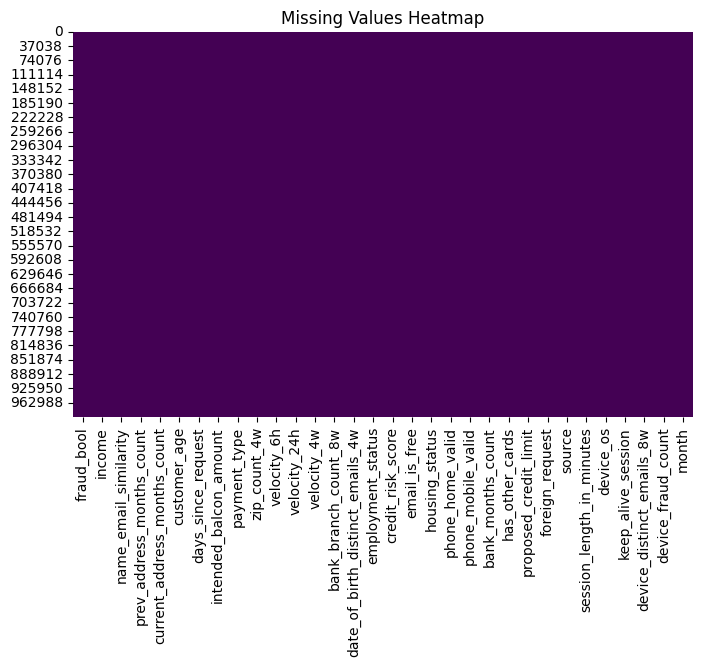

In [33]:
# Missing values heatmap
plt.figure(figsize=(8,5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

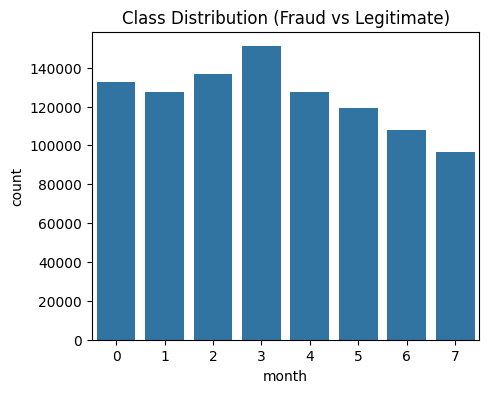

In [6]:
# Class distribution
plt.figure(figsize=(5,4))
sns.countplot(x=df[df.columns[-1]])
plt.title("Class Distribution (Fraud vs Legitimate)")
plt.show()

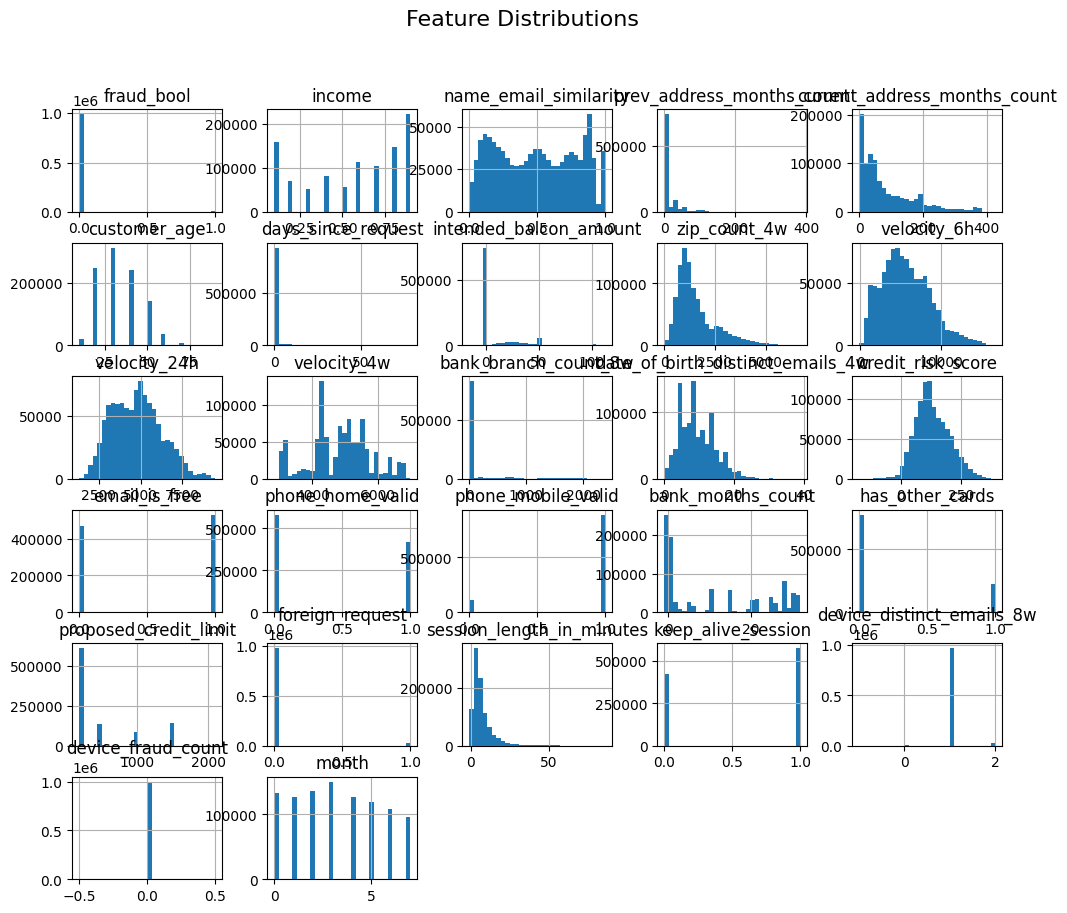

In [7]:
# Feature distributions (numeric only)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols].hist(figsize=(12,10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

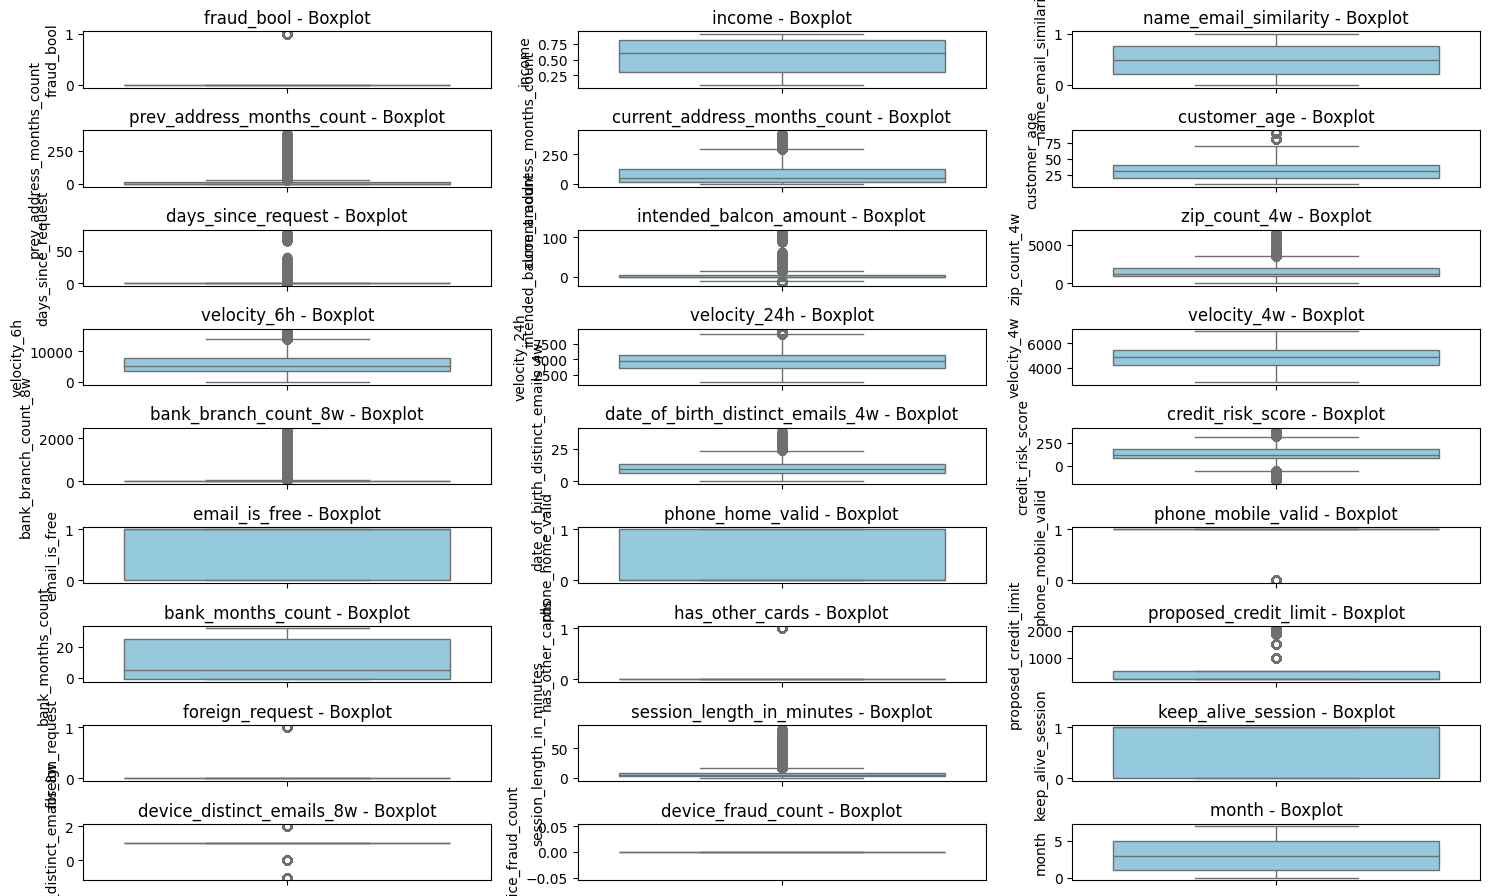

In [8]:
# Boxplots for outliers
plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot((len(num_cols)//3)+1, 3, i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f"{col} - Boxplot")
plt.tight_layout()
plt.show()

# **3. Data Preprocessing**

In [9]:
# Remove unnamed columns if any
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [10]:
# Fill missing values
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

/tmp/ipython-input-3298666522.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-3298666522.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [11]:
# Encode categorical columns
label_enc = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = label_enc.fit_transform(df[col])

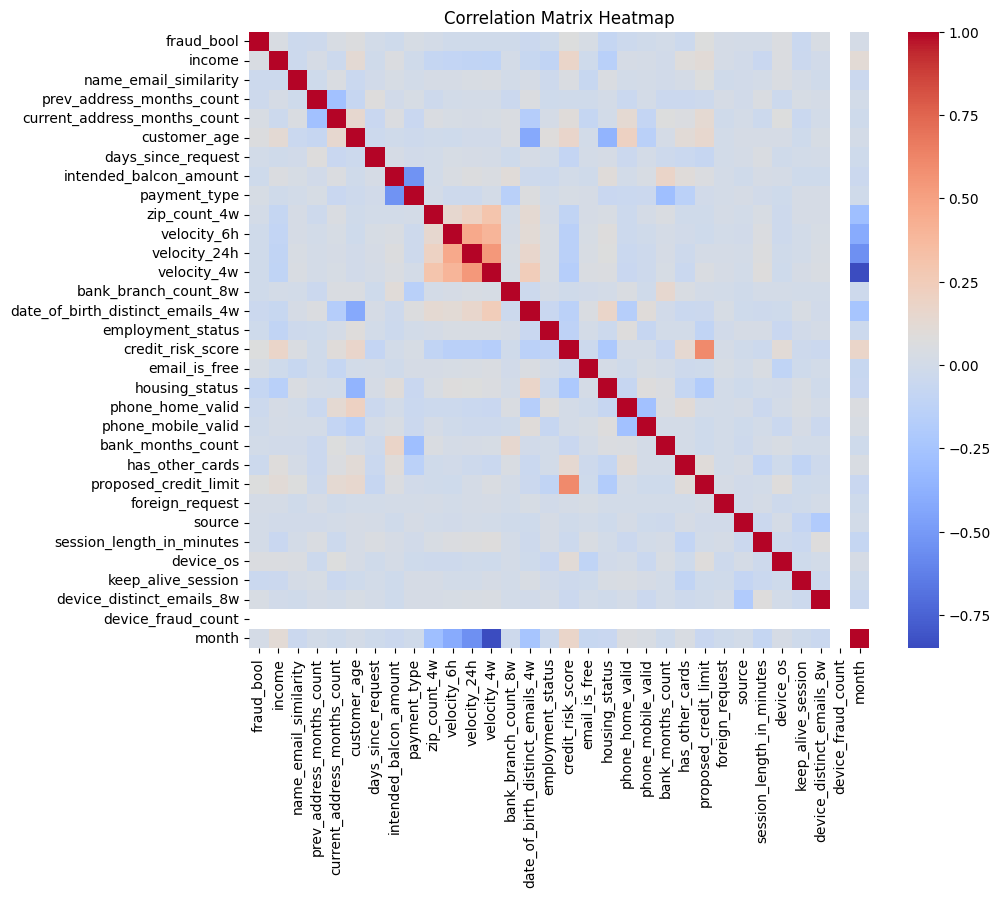

In [12]:
# Correlation matrix heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [13]:
# Outlier removal using IQR
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

# **4. Feature & Target Split**

In [14]:
target_column = df.columns[-1]
X = df.drop(target_column, axis=1)
y = df[target_column]

In [15]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# **5. Model Training & Evaluation**


===== Logistic Regression =====
Accuracy: 0.5725
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      3666
           1       0.49      0.29      0.36      3662
           2       0.50      0.60      0.55      4948
           3       0.52      0.66      0.58      5773
           4       0.39      0.27      0.32      5218
           5       0.49      0.51      0.50      5370
           6       0.51      0.51      0.51      4941
           7       0.80      0.89      0.84      5198

    accuracy                           0.57     38776
   macro avg       0.57      0.57      0.56     38776
weighted avg       0.56      0.57      0.56     38776



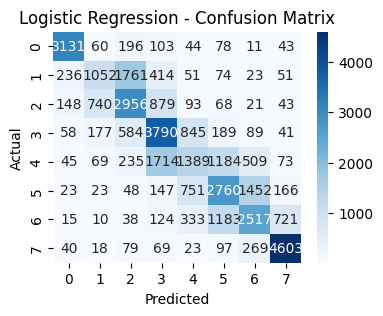


===== Random Forest =====
Accuracy: 0.6310
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      3666
           1       0.62      0.47      0.53      3662
           2       0.58      0.65      0.62      4948
           3       0.57      0.76      0.65      5773
           4       0.43      0.19      0.26      5218
           5       0.51      0.63      0.56      5370
           6       0.58      0.59      0.59      4941
           7       0.92      0.87      0.89      5198

    accuracy                           0.63     38776
   macro avg       0.64      0.63      0.62     38776
weighted avg       0.63      0.63      0.62     38776



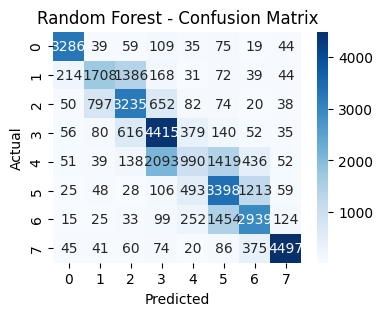


===== XGBoost =====


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:26:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.6475
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      3666
           1       0.64      0.56      0.60      3662
           2       0.62      0.65      0.63      4948
           3       0.60      0.72      0.66      5773
           4       0.48      0.30      0.37      5218
           5       0.52      0.65      0.58      5370
           6       0.59      0.58      0.59      4941
           7       0.91      0.86      0.89      5198

    accuracy                           0.65     38776
   macro avg       0.65      0.65      0.65     38776
weighted avg       0.65      0.65      0.64     38776



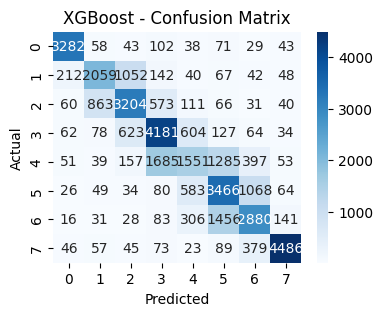


===== MLP Neural Network =====
Accuracy: 0.6428
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89      3666
           1       0.66      0.48      0.56      3662
           2       0.60      0.70      0.65      4948
           3       0.60      0.70      0.65      5773
           4       0.43      0.32      0.37      5218
           5       0.52      0.68      0.59      5370
           6       0.62      0.52      0.56      4941
           7       0.92      0.87      0.89      5198

    accuracy                           0.64     38776
   macro avg       0.65      0.64      0.64     38776
weighted avg       0.64      0.64      0.64     38776



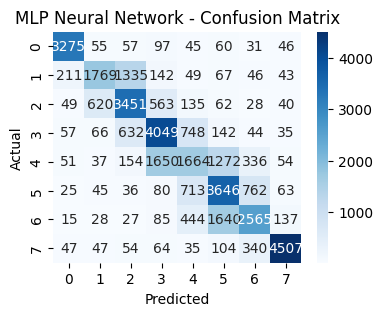

In [41]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "MLP Neural Network": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# **6. Accuracy Comparison**

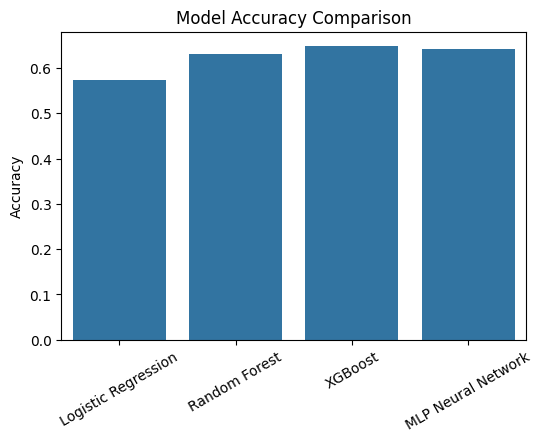

In [42]:
plt.figure(figsize=(6,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.show()


# **7. Select Best Model**

In [43]:
best_model_name = max(results, key=results.get)
print(f"\nBest performing model is: {best_model_name} with Accuracy: {results[best_model_name]:.4f}")


Best performing model is: XGBoost with Accuracy: 0.6475


In [44]:
import joblib

# Assuming 'best_model_name' and 'models' dictionary are available from previous steps
best_model = models[best_model_name]

# Save the best model to a file
filename = f"{best_model_name.replace(' ', '_').lower()}_model.joblib"
joblib.dump(best_model, filename)

print(f"Saved best model to {filename}")

Saved best model to xgboost_model.joblib
